100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s] 


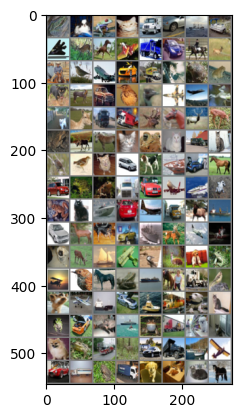

frog  dog   frog  cat   truck car   ship  ship  plane deer  horse plane truck car   horse deer  horse bird  plane car   truck cat   frog  frog  dog   horse car   bird  bird  plane plane frog  dog   deer  truck truck deer  horse deer  deer  frog  deer  horse cat   frog  cat   truck cat   bird  bird  dog   car   dog   ship  car   horse car   frog  frog  truck car   plane ship  frog  frog  cat   ship  car   plane truck deer  ship  car   deer  dog   car   ship  deer  plane horse dog   deer  ship  plane bird  deer  dog   frog  plane bird  horse frog  ship  horse truck bird  dog   plane ship  car   ship  plane dog   cat   frog  car   cat   ship  frog  truck dog   cat   dog   frog  truck deer  car   truck ship  plane car   truck frog  truck dog   cat   cat   horse


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# functions to show an image
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
from _model import *

device=torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
net = ResNet20().to(device)

In [ ]:
# 10 class
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
epochs = 200

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)



CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# first 5 classes
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.nn as nn

# 假设 train_transform 和 batch_size 已经定义
# ... (例如 batch_size = 64)
criterion = nn.CrossEntropyLoss()
epochs = 100

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)





# CIFAR-10 的所有类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 1. 定义我们想要的类别及其索引 (0到4)
TARGET_CLASSES_NAMES = classes[:5]
TARGET_CLASSES_INDICES = list(range(5))  # 0, 1, 2, 3, 4
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
# --- 载入原始完整训练集 ---
trainset_full = torchvision.datasets.CIFAR10(root='CIFAR10/', 
                                             train=True,
                                             download=True, 
                                             transform=train_transform)

# 2. 筛选数据集：获取所有属于目标类别的样本的索引
indices_to_keep = []
for i, label in enumerate(trainset_full.targets):
    # trainset_full.targets 是一个包含所有样本标签（0-9）的列表
    if label in TARGET_CLASSES_INDICES:
        indices_to_keep.append(i)

# 3. 创建子集 (Subset)
# Subset 类接受原始数据集和要保留的索引列表
trainset_subset = Subset(trainset_full, indices_to_keep)

# 4. 载入筛选后的数据
trainloader = torch.utils.data.DataLoader(trainset_subset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)

# 5. 可选：检查结果
print(f"原始训练集大小: {len(trainset_full)}")
print(f"筛选后的训练集大小: {len(trainset_subset)}")
print(f"筛选后的类别: {TARGET_CLASSES_NAMES}")

# --- 测试集保持不变（使用您原来的代码，假设您不筛选测试集）---
testset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

原始训练集大小: 50000
筛选后的训练集大小: 25000
筛选后的类别: ('plane', 'car', 'bird', 'cat', 'deer')


In [16]:
# last 5 classes
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

# 假设 train_transform 和 batch_size 已经定义
# ... (例如 batch_size = 64)
criterion = nn.CrossEntropyLoss()
epochs = 100

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# CIFAR-10 的所有类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 1. 定义我们想要的类别及其索引 (0到4)
TARGET_CLASSES_NAMES = classes[5:-1]
TARGET_CLASSES_INDICES = list(range(5,10))  #5,6,7,8,9,10

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
# --- 载入原始完整训练集 ---
trainset_full = torchvision.datasets.CIFAR10(root='CIFAR10/', 
                                             train=True,
                                             download=True, 
                                             transform=train_transform)

# 2. 筛选数据集：获取所有属于目标类别的样本的索引
indices_to_keep = []
for i, label in enumerate(trainset_full.targets):
    # trainset_full.targets 是一个包含所有样本标签（0-9）的列表
    if label in TARGET_CLASSES_INDICES:
        indices_to_keep.append(i)

# 3. 创建子集 (Subset)
# Subset 类接受原始数据集和要保留的索引列表
trainset_subset = Subset(trainset_full, indices_to_keep)

# 4. 载入筛选后的数据
trainloader = torch.utils.data.DataLoader(trainset_subset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)

# 5. 可选：检查结果
print(f"原始训练集大小: {len(trainset_full)}")
print(f"筛选后的训练集大小: {len(trainset_subset)}")
print(f"筛选后的类别: {TARGET_CLASSES_NAMES}")

# --- 测试集保持不变（使用您原来的代码，假设您不筛选测试集）---
testset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

原始训练集大小: 50000
筛选后的训练集大小: 25000
筛选后的类别: ('dog', 'frog', 'horse', 'ship')


In [17]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 190== 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 190:.3f}')
            running_loss = 0.0
        scheduler.step()

print('Finished Training')

[1,     1] loss: 0.013
[1,   191] loss: 1.007
[2,     1] loss: 0.004
[2,   191] loss: 0.735
[3,     1] loss: 0.005
[3,   191] loss: 0.568
[4,     1] loss: 0.003
[4,   191] loss: 0.480
[5,     1] loss: 0.003
[5,   191] loss: 0.409
[6,     1] loss: 0.002
[6,   191] loss: 0.368
[7,     1] loss: 0.003
[7,   191] loss: 0.337
[8,     1] loss: 0.001
[8,   191] loss: 0.318
[9,     1] loss: 0.001
[9,   191] loss: 0.305
[10,     1] loss: 0.001
[10,   191] loss: 0.282
[11,     1] loss: 0.002
[11,   191] loss: 0.269
[12,     1] loss: 0.001
[12,   191] loss: 0.253
[13,     1] loss: 0.001
[13,   191] loss: 0.245
[14,     1] loss: 0.001
[14,   191] loss: 0.243
[15,     1] loss: 0.001
[15,   191] loss: 0.236
[16,     1] loss: 0.001
[16,   191] loss: 0.228
[17,     1] loss: 0.000
[17,   191] loss: 0.223
[18,     1] loss: 0.001
[18,   191] loss: 0.213
[19,     1] loss: 0.001
[19,   191] loss: 0.209
[20,     1] loss: 0.001
[20,   191] loss: 0.208
[21,     1] loss: 0.001
[21,   191] loss: 0.201
[22,     1

In [18]:
Path =f"saved_cnn/_l5cifar10_cnn.pt"
torch.save(net.state_dict(), Path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


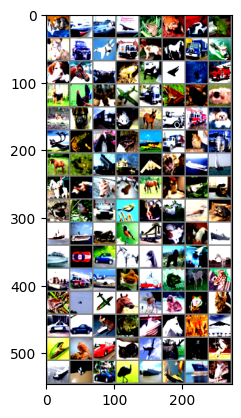

GroundTruth:  cat   ship  ship  plane


In [19]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [20]:
net = ResNet20()
Path= f"saved_cnn/_l5cifar10_cnn.pt"
net.load_state_dict(torch.load(Path, weights_only=True))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Predicted:  dog   ship  ship  ship 
Accuracy of the network on the 10000 test images: 44 %


In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 82.7 %
Accuracy for class: frog  is 88.4 %
Accuracy for class: horse is 92.1 %
Accuracy for class: ship  is 94.7 %
Accuracy for class: truck is 90.7 %
